In [1]:
import numpy as np
import pandas as pd
import biogeme
import sklearn
from lightgbm import LGBMClassifier

In [2]:
ned_data_rp = pd.read_table("Data/netherlandsRP.dat")
ned_data = pd.read_table("Data/netherlands.dat")

In [12]:
len(ned_data.columns)

28

In [3]:
ned_data['choice'] = ned_data.choice.replace(to_replace=[10, 11], value=[0, 1])

In [4]:
X = ned_data[['rail_cost', 'car_cost']]
y = ned_data['choice']

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=1)

In [13]:
lightGBM = LGBMClassifier(n_estimators = 30, 
                          max_depth = 5, 
                          num_leaves = 10, 
                          reg_alpha = 0.2, 
                          monotone_constraints = [-1, -1],
                          interaction_contraints = [[0], [1]])

In [14]:
eval_set = [(X_validate, y_validate)]
lightGBM.fit(X_train, y_train, eval_set=eval_set)

[LightGBM] [Warning] Unknown parameter: interaction_contraints
[1]	valid_0's binary_logloss: 0.572586
[2]	valid_0's binary_logloss: 0.571961
[3]	valid_0's binary_logloss: 0.571526
[4]	valid_0's binary_logloss: 0.571225
[5]	valid_0's binary_logloss: 0.571062
[6]	valid_0's binary_logloss: 0.570924
[7]	valid_0's binary_logloss: 0.570879
[8]	valid_0's binary_logloss: 0.570831
[9]	valid_0's binary_logloss: 0.57085
[10]	valid_0's binary_logloss: 0.570851
[11]	valid_0's binary_logloss: 0.570904
[12]	valid_0's binary_logloss: 0.570931
[13]	valid_0's binary_logloss: 0.570944
[14]	valid_0's binary_logloss: 0.570947
[15]	valid_0's binary_logloss: 0.570955
[16]	valid_0's binary_logloss: 0.570982
[17]	valid_0's binary_logloss: 0.571029
[18]	valid_0's binary_logloss: 0.57104
[19]	valid_0's binary_logloss: 0.571067
[20]	valid_0's binary_logloss: 0.571107
[21]	valid_0's binary_logloss: 0.571144
[22]	valid_0's binary_logloss: 0.571163
[23]	valid_0's binary_logloss: 0.571182
[24]	valid_0's binary_loglos

LGBMClassifier(interaction_contraints=[[0], [1]], max_depth=5,
               monotone_constraints=[-1, -1], n_estimators=30, num_leaves=10,
               reg_alpha=0.2)

In [15]:
y_pred=lightGBM.predict(X_validate)

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
accuracy_score(y_validate, y_pred)

0.7413793103448276

In [11]:
import biogeme.database as db
train_data = X_train.join(y_train)
database = db.Database("ned_data", train_data)
globals().update(database.variables)

In [12]:
from biogeme.expressions import Beta

ASC_c = Beta('ASC_c',0,None,None,0)
ASC_pt = Beta('ASC_pt', 0,None,None,1)

B_COST_c = Beta('B_COST_c', 0, None, None, 0)
B_COST_pt = Beta('B_COST_pt', 0, None, None, 0)

In [34]:
V_c = ASC_c + B_COST_c * car_cost/100
V_pt = ASC_pt + B_COST_pt * rail_cost/100
V = {0: V_c, 1: V_pt}

In [35]:
avail = {0: 1, 1: 1}

In [18]:
import biogeme.models as models

import biogeme.messaging as msg
import biogeme.biogeme as bio

# observation to the log likelihood function.
logprob = models.loglogit(V, None, choice)

# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
#biogeme.modelName = '01logit'

# Calculate the null log likelihood for reporting.
biogeme.calculateNullLoglikelihood(avail)

# Estimate the parameters
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
print(pandasResults)


NameError: name 'V' is not defined

In [37]:
cost_rail = np.arange(0, 120, 0.1)
B = -pandasResults.loc['B_COST_pt', 'Value'] / pandasResults.loc['B_COST_c', 'Value']
C = -pandasResults.loc['ASC_c', 'Value']/ pandasResults.loc['B_COST_c', 'Value']
cost_car = B*cost_rail + C

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
x_search = np.arange(0, 120, 2)
y_search = np.arange(0, 120, 2)

In [24]:
feature_like = []
for i in x_search:
    for j in y_search:
        
        feature_like.append([i, j])

In [25]:
data = lightGBM.predict_proba(feature_like)

In [26]:
data_inter = data[:, 0].reshape((len(x_search), len(y_search)))

In [27]:
from scipy.interpolate import RegularGridInterpolator

interp = RegularGridInterpolator((x_search, y_search), data_inter, bounds_error=False)

In [28]:
def fs(x):
    return np.squeeze([interp([x[0], x[1]]) - 0.5, interp([x[0], x[1]]) - 0.5])

In [42]:
from scipy.optimize import fsolve
from numpy.random import rand, seed

seed(10)

x_random = rand(10000)*120
y_random = rand(10000)*120

roots = np.array([fsolve(fs, [i, j]) for i,j in zip(x_random, y_random)])


C:\Users\nicol\anaconda3\envs\biogeme\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [43]:
mask = (interp(roots) == 0.5)

In [44]:
roots_fined = roots[mask]

In [51]:
fsolve(fs, [4, 4])

array([ 4.       , 66.8135111])

C:\Users\nicol\anaconda3\envs\biogeme\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nicol\anaconda3\envs\biogeme\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 120.0)

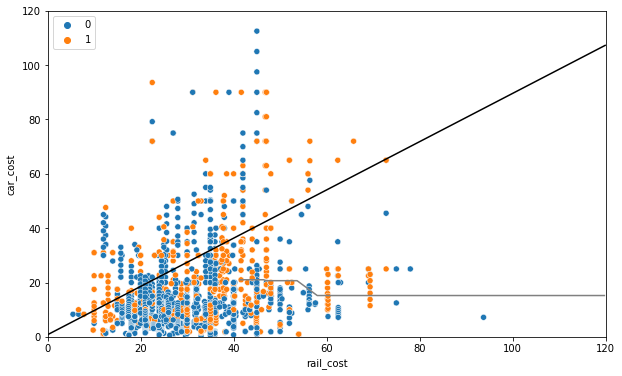

In [52]:
plt.figure(figsize=(10, 6))

data_plot = X.join(y)

sns.scatterplot(x='rail_cost', y='car_cost', hue='choice', data= data_plot, legend)
sns.lineplot(cost_rail, cost_car, color='k')
sns.lineplot(roots_fined[:, 0], roots_fined[:, 1], color = 'gray')
plt.legend(title='Equal choice prediction probability', loc='upper left', labels=['Utility', 'GBM'])
plt.xlim([0, 120])
plt.ylim([0, 120])